# SGH x Mastercard Hackathon - May 2025

## Fraud detection model

Let's start by setting up the project and installing requirements

In [1]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Next, we import the packages we'll need for data processing, feature engineering, model training and evaluation

In [2]:
from pathlib import Path
import time
import joblib
from typing import Callable, TypeVar, ParamSpec
from dataclasses import dataclass

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier, XGBRFClassifier

import optuna

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

C:\Users\alwoj\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1. Data ingestion

In [3]:
R = TypeVar("R")
P = ParamSpec("P")

# to obtain cleaner stack trace if wrong path is passed
def with_file_existence_checked(func: Callable[P, R]) -> Callable[P, R]:
    def _inner(file_path: Path, *args: P.args, **kwargs: P.kwargs) -> R:
        if not file_path.is_file():
            raise ValueError(f"file {file_path} doesn't exist")

        return func(file_path, *args, **kwargs)
    return _inner


@with_file_existence_checked
def read_transactions(transaction_path: Path) -> pd.DataFrame:
    data_transactions = pd.read_json(transaction_path, lines=True)
    location_df = pd.json_normalize(data_transactions['location'])
    location_df.columns = ['latitude', 'longitude']
    
    return data_transactions.drop(columns=['location']).join(location_df)


@with_file_existence_checked
def read_merchant_data(merchant_path: Path) -> pd.DataFrame:
    return pd.read_csv(merchant_path)


@with_file_existence_checked
def read_user_data(user_path: Path) -> pd.DataFrame:
    return pd.read_csv(user_path)


Once the files are loaded we can proceed to merge them together into one dataset

In [4]:
def get_raw_dataset(transaction_data: pd.DataFrame, merchant_data: pd.DataFrame, user_data: pd.DataFrame) -> pd.DataFrame:
    return transaction_data.merge(merchant_data, on='merchant_id', how='left').merge(user_data, on='user_id', how='left')

In [5]:
def ingest_data() -> pd.DataFrame():
    data_transactions = read_transactions(Path("data/transactions.json").resolve())
    data_merchants = read_merchant_data(Path("data/merchants.csv").resolve())
    data_users = read_user_data(Path("data/users.csv").resolve())
    
    return get_raw_dataset(data_transactions, data_merchants, data_users)

In [7]:
df = ingest_data()

## Step 2. Data pre-processing and feature engineering

In [8]:
def log_execution(func: Callable[P, R]) -> Callable[P, R]:
    def _inner(*args: P.args, **kwargs: P.kwargs) -> R:
        start = time.perf_counter()
        print(f"Executing transformation {func.__name__}")
        result = func(*args, **kwargs)
        print(f"Transformation {func.__name__} executed in {time.perf_counter() - start} seconds.")
        return result
    return _inner

In [9]:
# 1. Sort transactions by user and timestamp
@log_execution
def sort_by_user_id_and_timestamp(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(by=["user_id", "timestamp"])
    return df.reset_index(drop=True)

# 2. Add a binary column indicating whether the user has committed fraud before
@log_execution
def add_user_fraud_history(df: pd.DataFrame) -> pd.DataFrame:
    df['temp_cumulative_fraud'] = df.groupby('user_id')['is_fraud'].cumsum()
    shifted = df.groupby('user_id')['temp_cumulative_fraud'].shift(1)
    df['user_has_fraud_history'] = shifted.fillna(0).gt(0).astype(int)
    return df.drop(columns=['temp_cumulative_fraud'])

# 3. Add a column counting number of transactions by the user
@log_execution
def add_user_transaction_count(df: pd.DataFrame) -> pd.DataFrame:
    df["dummy"] = 1
    df["users_transaction_count"] = df.groupby("user_id")["dummy"].cumsum().astype(int)
    return df.drop(columns=["dummy"])

# 4. Add all user-based temporal and statistical features
@log_execution
def add_user_time_and_amount_features(df: pd.DataFrame) -> pd.DataFrame:
    df['time_since_last_transaction_user'] = df.groupby('user_id')['timestamp'].diff().dt.days
    df['time_since_last_transaction_user'] = df['time_since_last_transaction_user'].fillna(0).astype(int)
    
    # Amount deviation from user history
    df['transaction_amount_std_from_user_mean'] = (
        df.groupby('user_id')['amount']
        .transform(lambda x: (x.expanding().mean().shift(1) - x) / x.expanding().std().shift(1))
    )
    df['transaction_amount_std_from_user_mean'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df['transaction_amount_std_from_user_mean'].fillna(0, inplace=True)

    # Time-based features
    df['signup_date'] = pd.to_datetime(df['signup_date'])
    df['transaction_date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['days_since_signup'] = (df['transaction_date'] - df['signup_date']).dt.total_seconds() // (24 * 3600)
    df['days_since_signup'] = df['days_since_signup'].astype(int)

    df['transaction_hour'] = df['transaction_date'].dt.hour
    df['is_transaction_night'] = ((df['transaction_hour'] >= 0) & (df['transaction_hour'] < 6)).astype(int)

    return df

# 5. Add rolling transaction counts in the last N hours for each user
@log_execution
def add_rolling_transaction_counts(df: pd.DataFrame) -> pd.DataFrame:
    df['transactions_last_1h_user'] = (
        df.groupby('user_id', group_keys=False)
        .apply(lambda g: rolling_count(g, '1h'))
        .sort_index()
    )
    df['transactions_last_24h_user'] = (
        df.groupby('user_id', group_keys=False)
        .apply(lambda g: rolling_count(g, '24h'))
        .sort_index()
    )
    return df

# 6. Add moving average of user's past transaction amounts
@log_execution
def add_avg_amount_last_5_tx(df: pd.DataFrame) -> pd.DataFrame:
    df['avg_amount_last_5_tx_user'] = (
        df.groupby('user_id')['amount']
        .transform(lambda x: x.rolling(window=5, min_periods=1).mean().shift(1))
    )
    df['avg_amount_last_5_tx_user'].fillna(0, inplace=True)
    return df

# 7. Add merchant fraud history
@log_execution
def add_merchant_fraud_history(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values(by=["merchant_id", "timestamp"]).reset_index(drop=True)
    df['temp_cumulative_fraud'] = df.groupby('merchant_id')['is_fraud'].cumsum()
    shifted = df.groupby('merchant_id')['temp_cumulative_fraud'].shift(1)
    df['merchant_has_fraud_history'] = shifted.fillna(0).gt(0).astype(int)
    return df.drop(columns=['temp_cumulative_fraud'])

# 8. Add binary indicator whether user changed device from their usual one
@log_execution
def add_device_change_feature(df: pd.DataFrame) -> pd.DataFrame:
    df['user_mode_device_temp'] = df.groupby('user_id')['device'].transform(_get_user_device_mode_for_transform)
    has_mode = df['user_mode_device_temp'].notna()
    df['device_changed'] = 0
    df.loc[has_mode, 'device_changed'] = (
        (df.loc[has_mode, 'device'] != df.loc[has_mode, 'user_mode_device_temp']).astype(int)
    )
    return df.drop(columns=['user_mode_device_temp'])

# Helper function for rolling count
def rolling_count(series, window):
    # series is a DataFrame with 'transaction_date'
    return series['transaction_date'].apply(
        lambda x: ((series['transaction_date'] >= (x - pd.Timedelta(window))) & (series['transaction_date'] < x)).sum()
    )

def _get_user_device_mode_for_transform(series):
    # Ensure numpy is imported in your notebook, e.g., import numpy as np
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    return np.nan


In [10]:
@log_execution
def add_temporal_pattern_features(df_cleaned: pd.DataFrame) -> pd.DataFrame:
    """1. Temporal Pattern Features"""
    df_cleaned['day_of_week'] = df_cleaned['transaction_date'].dt.dayofweek
    df_cleaned['is_weekend'] = (df_cleaned['transaction_date'].dt.dayofweek >= 5).astype(int)

    df_cleaned = df_cleaned.sort_values(by=["user_id", "timestamp"]).reset_index(drop=True)
    df_cleaned['user_tx_velocity_15m'] = (
        df_cleaned.groupby('user_id', group_keys=False)
        .apply(lambda group: rolling_count(group, '15m'))
        .sort_index()
    ).astype(int)
    return df_cleaned


@log_execution
def add_high_risk_merchant_features(df_cleaned: pd.DataFrame) -> pd.DataFrame:
    """2. High-Risk Merchant Features"""
    df_cleaned = df_cleaned.sort_values(by=["merchant_id", "timestamp"]).reset_index(drop=True)

    df_cleaned['merchant_past_tx_count'] = df_cleaned.groupby('merchant_id').cumcount()
    df_cleaned['merchant_past_fraud_count'] = (
        df_cleaned.groupby('merchant_id')['is_fraud']
        .transform(lambda x: x.shift(1).expanding().sum())
        .fillna(0)
        .astype(int)
    )

    df_cleaned['merchant_past_fraud_rate'] = (
        df_cleaned['merchant_past_fraud_count'] /
        (df_cleaned['merchant_past_tx_count'] + 1e-6)
    ).replace([np.inf, -np.inf], 0).fillna(0)

    df_cleaned['merchant_avg_amount_hist'] = (
        df_cleaned.groupby('merchant_id')['amount']
        .transform(lambda x: x.shift(1).expanding().mean())
        .fillna(0)
    )

    df_cleaned['amount_vs_merchant_avg_ratio'] = (
        df_cleaned['amount'] / (df_cleaned['merchant_avg_amount_hist'] + 1e-6)
    ).replace([np.inf, -np.inf], 0).fillna(0)

    return df_cleaned


@log_execution
def add_cardholder_anomaly_features(df_cleaned: pd.DataFrame) -> pd.DataFrame:
    """3. Cardholder Behavior Anomaly Features"""
    df_cleaned = df_cleaned.sort_values(by=["user_id", "timestamp"]).reset_index(drop=True)

    if 'avg_amount_last_5_tx_user' in df_cleaned.columns:
        df_cleaned['amount_vs_user_avg_5tx_ratio'] = (
            df_cleaned['amount'] / (df_cleaned['avg_amount_last_5_tx_user'] + 1e-6)
        ).replace([np.inf, -np.inf], 0).fillna(0)
    else:
        print("Warning: Column 'avg_amount_last_5_tx_user' not found. Skipping 'amount_vs_user_avg_5tx_ratio' feature.")

    df_cleaned['is_new_merchant_for_user'] = (
        df_cleaned.groupby(['user_id', 'merchant_id']).cumcount() == 0
    ).astype(int)

    return df_cleaned


@log_execution
def finalize_feature_processing(df_cleaned: pd.DataFrame) -> pd.DataFrame:
    """Final sort and column cleanup"""
    df_cleaned = df_cleaned.sort_values(by=["user_id", "timestamp"]).reset_index(drop=True)
    df_cleaned = df_cleaned.drop(columns=['transaction_date', 'signup_date'])
    return df_cleaned

In [11]:
def preprocess_data(data: pd.DataFrame) -> pd.DataFrame:
    data["education"] = data["education"].fillna("No Education")

    df_cleaned = data.drop(columns = ["transaction_id", "currency"])

    transformations = (
        sort_by_user_id_and_timestamp,
        add_user_fraud_history,
        add_user_transaction_count,
        add_user_time_and_amount_features,
        add_rolling_transaction_counts,
        add_avg_amount_last_5_tx,
        add_merchant_fraud_history,
        add_device_change_feature,
        add_temporal_pattern_features,
        add_high_risk_merchant_features,
        add_cardholder_anomaly_features,
        finalize_feature_processing,
    )

    with tqdm(desc="data_preprocessing...", total=len(transformations)) as pbar:
        for func in transformations:
            df_cleaned = func(df_cleaned)
            pbar.update(1)

    return df_cleaned      

In [12]:
df = preprocess_data(df)

data_preprocessing...:   0%|                                                                    | 0/12 [00:00<?, ?it/s]

Executing transformation sort_by_user_id_and_timestamp


data_preprocessing...:   8%|█████                                                       | 1/12 [00:01<00:13,  1.27s/it]

Transformation sort_by_user_id_and_timestamp executed in 1.2008207999169827 seconds.
Executing transformation add_user_fraud_history


data_preprocessing...:  17%|██████████                                                  | 2/12 [00:02<00:09,  1.04it/s]

Transformation add_user_fraud_history executed in 0.6851530000567436 seconds.
Executing transformation add_user_transaction_count


data_preprocessing...:  25%|███████████████                                             | 3/12 [00:02<00:06,  1.39it/s]

Transformation add_user_transaction_count executed in 0.37757759960368276 seconds.
Executing transformation add_user_time_and_amount_features


data_preprocessing...:  33%|████████████████████                                        | 4/12 [00:11<00:30,  3.84s/it]

Transformation add_user_time_and_amount_features executed in 8.635619099717587 seconds.
Executing transformation add_rolling_transaction_counts


data_preprocessing...:  42%|█████████████████████████                                   | 5/12 [03:33<08:47, 75.34s/it]

Transformation add_rolling_transaction_counts executed in 202.10839200019836 seconds.
Executing transformation add_avg_amount_last_5_tx


data_preprocessing...:  50%|██████████████████████████████                              | 6/12 [03:37<05:06, 51.05s/it]

Transformation add_avg_amount_last_5_tx executed in 3.896544899791479 seconds.
Executing transformation add_merchant_fraud_history


data_preprocessing...:  58%|███████████████████████████████████                         | 7/12 [03:38<02:53, 34.78s/it]

Transformation add_merchant_fraud_history executed in 1.244980700314045 seconds.
Executing transformation add_device_change_feature


data_preprocessing...:  67%|████████████████████████████████████████                    | 8/12 [03:41<01:38, 24.72s/it]

Transformation add_device_change_feature executed in 3.1203485997393727 seconds.
Executing transformation add_temporal_pattern_features


data_preprocessing...:  75%|█████████████████████████████████████████████               | 9/12 [05:15<02:18, 46.25s/it]

Transformation add_temporal_pattern_features executed in 93.55114300036803 seconds.
Executing transformation add_high_risk_merchant_features


data_preprocessing...:  83%|█████████████████████████████████████████████████▏         | 10/12 [05:16<01:04, 32.48s/it]

Transformation add_high_risk_merchant_features executed in 1.599934000056237 seconds.
Executing transformation add_cardholder_anomaly_features


data_preprocessing...:  92%|██████████████████████████████████████████████████████     | 11/12 [05:18<00:22, 22.95s/it]

Transformation add_cardholder_anomaly_features executed in 1.2858206001110375 seconds.
Executing transformation finalize_feature_processing


data_preprocessing...: 100%|███████████████████████████████████████████████████████████| 12/12 [05:19<00:00, 26.59s/it]

Transformation finalize_feature_processing executed in 0.8611949002370238 seconds.


## Step 3. Prepare train-test datasets

In [13]:
@dataclass
class DataSetRepo:
    X_train: pd.DataFrame
    y_train: pd.Series
    X_test: pd.DataFrame
    y_test: pd.Series
    

def prepare_datasets(df: pd.DataFrame) -> DataSetRepo:
    enc = OrdinalEncoder()

    X = df.drop(columns=["is_fraud"])
    y = df["is_fraud"]
    
    X = pd.DataFrame(enc.fit_transform(X), columns=X.columns)
    
    X_train_orig, X_test, y_train_orig, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
    )
    
    # Undersample only the training data
    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train_orig, y_train_orig)

    return DataSetRepo(
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
    )

In [14]:
repo = prepare_datasets(df)

## Step 4. Feature selection

In [15]:
def custom_cost_function(y_true, y_pred, cost_fn=10, cost_fp=3):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    fn_count = np.sum((y_true_arr == 1) & (y_pred_arr == 0))
    fp_count = np.sum((y_true_arr == 0) & (y_pred_arr == 1))
    return fn_count * cost_fn + fp_count * cost_fp

custom_scorer = make_scorer(custom_cost_function, greater_is_better=False)

# Recursive feature elimination with CV, supporting custom scorer

def rfe_with_cv(
    model_prototype,
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 3,
    scoring=custom_scorer,
    random_state: int = 42
):
    features = X.columns.tolist()
    best_score = np.inf  # lower cost is better
    best_features = features.copy()
    history = {}

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    while features:
        model = clone(model_prototype)
        scores = cross_val_score(
            model,
            X[features],
            y,
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )
        mean_score = np.mean(scores)
        history[len(features)] = mean_score

        if mean_score < best_score or (
            np.isclose(mean_score, best_score) and len(features) < len(best_features)
        ):
            best_score = mean_score
            best_features = features.copy()

        if len(features) == 1:
            break

        model_full = clone(model_prototype)
        model_full.fit(X[features], y)
        importances = pd.Series(
            model_full.feature_importances_,
            index=features
        )
        least_imp = importances.idxmin()
        features.remove(least_imp)

    print(f"RFE complete: lowest cost={best_score:.2f} with {len(best_features)} features.")
    return best_features, history

# Run RFE on balanced training data
xgb_prototype = XGBRFClassifier()
best_feats, rfe_history = rfe_with_cv(xgb_prototype, repo.X_train, repo.y_train)

RFE complete: lowest cost=-61477.33 with 1 features.


## Step 5. Model training

We will use `optuna` to search the hyperparameter space for configuration yielding optimal results 
for an XGBOOST classifier

In [16]:
# Use only the RFE-selected features
X_rfe = repo.X_train[best_feats]

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "n_jobs": -1,
        "eval_metric": "logloss",
        "use_label_encoder": False,
    }
    model = XGBRFClassifier(**params)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    # Return mean custom cost (lower is better)
    scores = cross_val_score(model, X_rfe, repo.y_train, cv=cv, scoring=custom_scorer, n_jobs=-1)
    return np.mean(scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Best params:", study.best_params)
print("Lowest cost:", study.best_value)


[I 2025-05-16 16:01:08,963] A new study created in memory with name: no-name-cb932ec3-18c0-4c62-80e5-f9082df04fa3
[I 2025-05-16 16:01:11,535] Trial 0 finished with value: -18443.2 and parameters: {'learning_rate': 0.025998396026039122, 'n_estimators': 92, 'max_depth': 7, 'subsample': 0.8213409383451991, 'colsample_bytree': 0.7856783120116833, 'gamma': 2.571488342329478}. Best is trial 0 with value: -18443.2.
[I 2025-05-16 16:01:14,566] Trial 4 finished with value: -18443.2 and parameters: {'learning_rate': 0.28326625772916514, 'n_estimators': 114, 'max_depth': 9, 'subsample': 0.63922427217496, 'colsample_bytree': 0.7506296717117744, 'gamma': 4.603164342353317}. Best is trial 0 with value: -18443.2.
[I 2025-05-16 16:01:15,255] Trial 1 finished with value: -18443.2 and parameters: {'learning_rate': 0.1002550291340687, 'n_estimators': 190, 'max_depth': 4, 'subsample': 0.8210918241086703, 'colsample_bytree': 0.7808313917428811, 'gamma': 2.1322153232666805}. Best is trial 0 with value: -184

Best params: {'learning_rate': 0.025998396026039122, 'n_estimators': 92, 'max_depth': 7, 'subsample': 0.8213409383451991, 'colsample_bytree': 0.7856783120116833, 'gamma': 2.571488342329478}
Lowest cost: -18443.2


In [17]:
final_model = XGBRFClassifier(**study.best_params)
final_model.fit(repo.X_train[best_feats], repo.y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=0.7856783120116833,
                device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                feature_weights=None, gamma=2.571488342329478, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=0.025998396026039122, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=7, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=92, n_jobs=None,
                num_parallel_tree=None, objective='binary:logistic', ...)

## Step 6. Evaluate model results

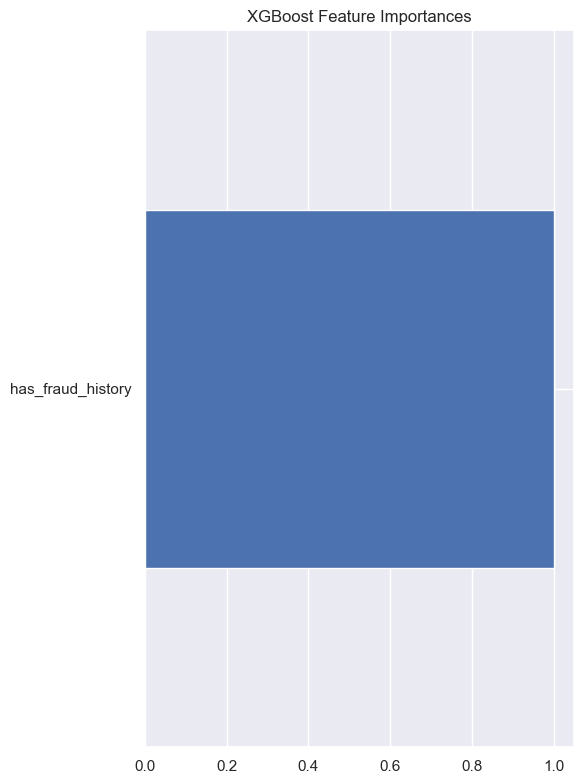

In [18]:
importances = pd.Series(final_model.feature_importances_, index=best_feats)
importances.sort_values().plot(kind='barh', figsize=(6,8))
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

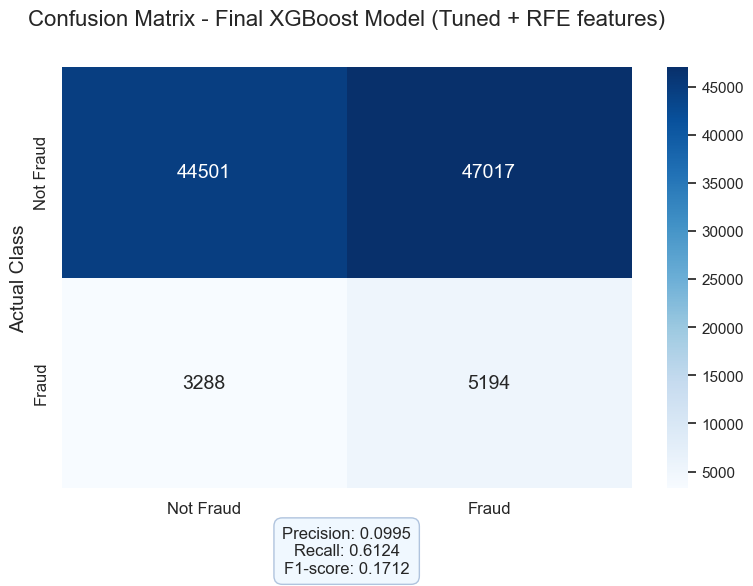

In [19]:
y_pred = final_model.predict(repo.X_test[best_feats])

cm = confusion_matrix(repo.y_test, y_pred)

precision = precision_score(repo.y_test, y_pred, zero_division=0)
recall = recall_score(repo.y_test, y_pred, zero_division=0)
accuracy = accuracy_score(repo.y_test, y_pred)
f1 = f1_score(repo.y_test, y_pred, zero_division=0)

# Define class labels for the plot
class_labels = ['Not Fraud', 'Fraud']

# Plotting the confusion matrix
plt.figure(figsize=(8, 7)) # Increased figure height slightly to accommodate metrics
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={"size": 14}) # Makes annotations easier to read

plt.title('Confusion Matrix - Final XGBoost Model (Tuned + RFE features)', fontsize=16, y=1.08) # Adjust title position
plt.ylabel('Actual Class', fontsize=14)
plt.xlabel('Predicted Class', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding precision, recall, and F1-score text below the heatmap
metrics_text = f"Accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-score: {f1:.4f}"
plt.text(0.5, -0.15, metrics_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', ec='lightsteelblue', lw=1))


plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout to prevent labels/text from overlapping, added bottom margin
plt.show()

## Save the final model

In [20]:
joblib.dump(final_model, Path(".") / "model.pkl")

['model.pkl']